# Nuclei Segmentation using Local Raman pixel clusters (i.e. neighbors of each pixel)

In [3]:
# general python utility packages
import os
import platform
import random
import shutil
import sys
import time
import datetime
import functools
import itertools as it
import copy

# data science packages
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras as K
from sklearn.utils import resample
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import anndata as ann
import h5py


# plotting packages
import seaborn as sns

import matplotlib.pyplot as plt

# local imports
import preprocess as pp
import train 
import utils


# recommended Python3 version >= 3.5
print('Python version: {}'.format(platform.sys.version))


# progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm_notebook as tqdm


# required TensorFlow version >= 2.0.0
tf_version = tf.__version__
print('TensorFlow version: {}'.format(tf_version))
assert int(tf_version[0]) >= 2, "Tensorflow version must be >= 2.0"

# seed random numbers for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print('\nImports Complete.')

preprocess imported
module name : preprocess module package: 
Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27) 
[Clang 9.0.1 ]
TensorFlow version: 2.1.0

Imports Complete.


In [88]:
#installations
!pip install keras-tuner

### Load data

In [131]:
# load in full dataset (un-balanced)
pp_file = 'preprocessed_data.h5'
raman_df_full = pd.read_hdf(pp_file, mode='r+', key='pp')

In [319]:
# get background
bg_mask = raman_df_full.background == True
bg = raman_df_full[bg_mask]

In [320]:
# get foreground
fg = raman_df_full[~bg_mask]

# remove null values 
fg = fg[~fg.background.isnull()]

In [321]:
# divide background spectra into train, test, val sets
train_bg_mask = bg.image.isin(['D13_Pos19', 'D11.5_Pos13'])
val_bg_mask = bg.image == 'D11_Pos4'
test_bg_mask = bg.image == 'D8_Pos4'

train_bg = bg[train_bg_mask]
val_bg = bg[val_bg_mask]
test_bg = bg[test_bg_mask]

In [323]:
# reset random seed
import time
random.seed(int(time.time()))
np.random.seed(int(time.time()))
tf.random.set_seed(int(time.time()))

In [324]:
# divide foreground spectra into train, test, val sets

# choose a random sampling of images to go in each set
fg_images = pd.Series(fg.image.unique())
train_im, test_im, val_im = np.split(fg_images, [int(len(fg_images)*.6), int(len(fg_images)*.8)])

# get dataframe with those images only
train_fg = fg[fg.image.isin(train_im)]
val_fg = fg[fg.image.isin(val_im)]
test_fg = fg[fg.image.isin(test_im)]

In [334]:
# make unbalanced datasets and save to .h5 file
x_train_pd = pd.concat([train_bg, train_fg])
x_test_pd = pd.concat([test_bg, test_fg])
x_val_pd = pd.concat([val_bg, val_fg])

# save to .h5 file
store_imb = pd.HDFStore('train_val_test_imb.h5')
store_imb['train'] = x_train_pd
print('training set saved')
store_imb['test'] = x_test_pd
print('testing set saved')
store_imb['val'] = x_val_pd
print('validation set saved')
store_imb.close()

/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  
/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  
/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['image', 'day', 'pos', 'cell_id', 'pixel_id', 'background']]

  exec(code_obj, self.user_global_ns, self.user_ns)


training set saved


/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  # Remove the CWD from sys.path while we load stuff.
/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  # Remove the CWD from sys.path while we load stuff.


testing set saved


/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/ipykernel_launcher.py:12: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  if sys.path[0] == '':


validation set saved


/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/ipykernel_launcher.py:12: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  if sys.path[0] == '':


In [318]:
# load train_test_val from h5 file
file = 'train_val_test_ds.h5'
x_train_pd = pd.read_hdf(file, mode='r+', key='x_train')
labels_train = pd.read_hdf(file, mode='r+', key='y_train')
x_val_pd = pd.read_hdf(file, mode='r+', key='x_val')
labels_val = pd.read_hdf(file, mode='r+', key='y_val')
x_test_pd = pd.read_hdf(file, mode='r+', key='x_test')
labels_test = pd.read_hdf(file, mode='r+', key='y_test')

# convert to numpy
x_train_np = x_train_pd.to_numpy()
x_val_np = x_val_pd.to_numpy()
x_test_np = x_test_pd.to_numpy()

# get full dataframes again
x_train_full = pd.concat([labels_train, x_train_pd], axis=1)
x_test_full = pd.concat([labels_val, x_val_pd], axis=1)
x_val_full = pd.concat([labels_test, x_test_pd], axis=1)

In [3]:
# convert training, validation sets and labels to tensors, labels one-hot encoded
# training set
x_train = tf.convert_to_tensor(x_train_np)
le_train = LabelEncoder()
y_le_train = le_train.fit_transform(~labels_train.background.to_numpy())
y_train = tf.one_hot(y_le_train,depth=2) 

# validation set
x_val = tf.convert_to_tensor(x_val_np)
le_val = LabelEncoder()
y_le_val = le_val.fit_transform(~labels_val.background.to_numpy())
y_val = tf.one_hot(y_le_val,depth=2) #refers to foreground

# test set
x_test = tf.convert_to_tensor(x_test_np)
le_test = LabelEncoder()
y_le_test = le_test.fit_transform(~labels_test.background.to_numpy())
y_test = tf.one_hot(y_le_test,depth=2) #refers to foreground

In [74]:
x, y = 10, 20
mask = x_train_full['image'] == 'D13_Pos19'
day_images = x_train_full[mask]
duo_mask = (day_images.pix_x == 84) & (day_images.pix_y == 77)
# day_images[duo_mask].index[0
day_images[duo_mask]

,image,day,pos,cell_id,pixel_id,pix_x,pix_y,background,0,1,...,920,921,922,923,924,925,926,927,928,929
43620,D13_Pos19,D13,Pos19,D13_Pos19_cell15,D13_Pos19_cell15_pix25,84.0,77.0,False,0.396188,1.28518,...,-2.790167,-1.568548,0.350659,-0.88775,-0.877704,-0.248378,0.961621,-3.907183,-3.82069,-2.700839


## Recast all spectra into tensors of size k x k x 930

### Recast dataframe spectra

In [10]:
# load in imbalanced dataset
# x_train_pd = pd.read_hdf('train_val_test_imb.h5', mode='a', key='train')
# x_test_pd = pd.read_hdf('train_val_test_imb.h5', mode = 'a', key='test')
# x_val_pd = pd.read_hdf('train_val_test_imb.h5', mode = 'a', key='val')

# load down-sampled dataset
x_train_pd = pd.read_hdf('train_val_test_ds.h5', mode='a', key='x_train')
x_test_pd = pd.read_hdf('train_val_test_ds.h5', mode = 'a', key='x_test')
x_val_pd = pd.read_hdf('train_val_test_ds.h5', mode = 'a', key='x_val')

y_train_pd = pd.read_hdf('train_val_test_ds.h5', mode='a', key='y_train')
y_test_pd = pd.read_hdf('train_val_test_ds.h5', mode = 'a', key='y_test')
y_val_pd = pd.read_hdf('train_val_test_ds.h5', mode = 'a', key='y_val')

x_train_pd = pd.concat([y_train_pd, x_train_pd], axis=1)
x_test_pd = pd.concat([y_test_pd, x_test_pd], axis=1)
x_val_pd = pd.concat([y_val_pd, x_val_pd], axis=1)

In [147]:
# make sure there aren't any overlapping images in train, val, or test sets
print(f'Images in both train and test: {set(x_train_pd.image).intersection(set(x_test_pd.image))}')
print(f'Images in both train and val: {set(x_train_pd.image).intersection(set(x_val_pd.image))}')
print(f'Images in both val and test: {set(x_val_pd.image).intersection(set(x_test_pd.image))}')

Images in both train and test: set()
Images in both train and val: {'D11.5_Pos13'}
Images in both val and test: {'D8_Pos4'}


In [19]:
# helper functions for getting nearest neighbors

# get nearest neighbors from a pandas dataframe, given pixel info

def image_mask(df, image):
    return df[df.image == image]


def get_neighbor_ix(x, y, k):
    ''' 
        Just returns a list of the pixels immediately around x and y, 
        enough to form a k x k grid
    '''
    ixs = list(range(-k//2+1, k//2+1))
    neighbor_pixels = [(x+i, y+j) for i in ixs for j in ixs]
    return neighbor_pixels


def get_neighbors_from_pixels(df, x, y, k=3):
    ''' 
        Given an x and y coordinate, find the k nearest neighbors of x and y. 
        Assumes that x and y coordinates come from same image
    '''
    # get list of local rows to consider: eg. k = 3 -> [-1,0,1]; k = 5 -> [-2, -1, 0, 1, 2]
    # get list of neighbors that would be 1 away
    neighbor_pixels = get_neighbor_ix(x, y, k)
    neighbors = []
    for n in neighbor_pixels:
        x_pix, y_pix = n[0], n[1]
        mask = (df.pix_x == x_pix) & (df.pix_y == y_pix)
        row = df[mask]
        if row.shape[0] > 0:
            neighbors.append(row)
    return pd.concat(neighbors, axis=0)


def impute_from_df_mean(mini_df, x, y, k=3, ix=8):
    ''' 
    Given the neighbors of x and y, assembles a 
    k x k tensor represnting the pixels around the point 
    x and y
    '''
    n = mini_df.shape[0]
    if n == k**2: return mini_df
    
    # if still missing values, imput with the mean of available values
    mean = mini_df.iloc[:,ix:].mean()
    prepend = mini_df.iloc[0,:4]
    bg_label = pd.Series({'background': mini_df.iloc[0,7]})
    cell_id = pd.Series({'cell_id': 'None'})
    
    neighbor_pixels = get_neighbor_ix(x, y, k)
    NEW_ROWS = []
    pixels_present = set(list(zip(mini_df.pix_x, mini_df.pix_y)))
    for pix_x, pix_y in neighbor_pixels:
        if (pix_x, pix_y) not in pixels_present:
            pixels = pd.Series({'pix_x':pix_x, 'pix_y':pix_y})
            new_row = pd.concat([prepend, pixels, bg_label, mean])
            NEW_ROWS.append(new_row)
    ADD_ROWS = pd.concat(NEW_ROWS, axis=1)
    return pd.concat([mini_df, ADD_ROWS.T], axis=0)


def assemble_tensor_from_df(mini_df, x_center, y_center, k=3):
    '''
        Given the x center and the y center, assemble two tensors
        around x_center and y_center - the tensor of spectra
        and a resulting label (either fg or bg)
    '''
    # sort df, then reshape
    sorted_df = mini_df.sort_values(['pix_x', 'pix_y'])
    sorted_np = sorted_df.iloc[:,8:].to_numpy()
    return np.reshape(sorted_np, newshape=(k,k,sorted_np.shape[1]))

In [450]:
def get_tensors_from_df(dataframe, k=3):
    ''' 
        Run through all the functions to get input tensors for 
        the neural network
    '''
    if k == 1:
        return dataframe.iloc[:,8:].to_numpy().astype('float64'), ~dataframe.background
    tensor_list = []
    labels = []
    # get image list
    image_list = dataframe.image.unique()
    for image in tqdm(image_list):
        print(f'image name: {image}')
        # get mask of that image
        df = image_mask(dataframe, image)
        for index, row in df.iterrows():
            cell_label = int(not row.background) # 1 for cell, 0 for bg
            x, y = row.pix_x, row.pix_y
            # get the mini_df
            neighbors = get_neighbors_from_pixels(df, x, y, k=3)
            # impute any missing values
            imp_neighbors = impute_from_df_mean(neighbors, x, y, k=k)
            # now assemble tensor
            tensor = assemble_tensor_from_df(imp_neighbors, x, y, k=k)
            tensor_list.append(tensor)
            labels.append(cell_label)
    test_tensors_np = np.array(tensor_list)
    return test_tensors_np.astype('float64'), np.array(labels)

In [205]:
# find neighbors for all pixels
df = raman_df_full[raman_df_full.image == ims[4]]
n_list = []
for index, row in (df.iterrows()):
    x, y = row.pix_x, row.pix_y
    neighbors = get_neighbors_from_pixels(df, x, y, k=3)
    n_list.append(neighbors)


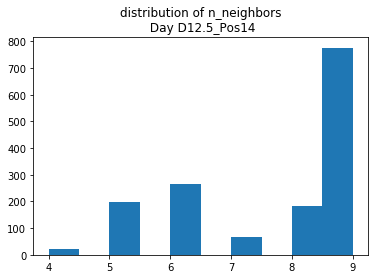

In [268]:
# look at histogram of num neighbors
n_sizes = np.array([n.shape[0] for n in n_list])
plt.hist(n_sizes)
plt.title(f'distribution of n_neighbors\n Day {ims[4]}');

### Save all as .h5 files for later use

In [22]:
import h5py

In [451]:
# convert train, test, and validation sets into tensors
# get test tensors
test_tensors, test_labels = get_tensors_from_df(x_test_pd, k=5)

image name: D12_Pos14


/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



image name: D8.5_Pos1
image name: D14_Pos1
image name: D11.5_Pos6
image name: D12_Pos18
image name: D12.5_Pos17
image name: D9_Pos19
image name: D14_Pos16
image name: D9.5_Pos17
image name: D11.5_Pos7
image name: D10_Pos12
image name: D12_Pos13
image name: D10.5_Pos18
image name: D13_Pos16
image name: D9_Pos4
image name: D9_Pos8
image name: D10_Pos19
image name: D9.5_Pos3
image name: D13_Pos11
image name: D12_Pos7
image name: D8.5_Pos6
image name: D9.5_Pos8
image name: D12.5_Pos10
image name: D11_Pos2
image name: D8_Pos5
image name: D11.5_Pos19
image name: D11_Pos5
image name: D9.5_Pos10
image name: D10.5_Pos8
image name: D12_Pos1
image name: D10_Pos4
image name: D13_Pos6
image name: D9_Pos12
image name: D11.5_Pos12
image name: D12.5_Pos1
image name: D10.5_Pos19
image name: D10.5_Pos14
image name: D10_Pos8
image name: D11_Pos17
image name: D11.5_Pos15
image name: D12_Pos0
image name: D11.5_Pos14
image name: D8_Pos4



In [33]:
# get test tensors
hf_test = h5py.File('ds_tf_tensors_test.h5', 'w')
hf_test.create_dataset('x_test', data=test_tensors)
hf_test.create_dataset('y_test', data=test_labels)
hf_test.close()

In [452]:
# get validation tensors
val_tensors, val_labels = get_tensors_from_df(x_val_pd, k=5)

image name: D14_Pos11


/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



image name: D9_Pos18
image name: D13_Pos1
image name: D12_Pos6
image name: D11_Pos8
image name: D9.5_Pos9
image name: D8.5_Pos11
image name: D13_Pos17
image name: D11_Pos9
image name: D14_Pos7
image name: D9_Pos15
image name: D12.5_Pos11
image name: D9.5_Pos11
image name: D8_Pos9
image name: D11_Pos4
image name: D8_Pos8
image name: D11.5_Pos1
image name: D12_Pos12
image name: D14_Pos10
image name: D14_Pos6
image name: D8_Pos4
image name: D9.5_Pos5
image name: D13_Pos0
image name: D12.5_Pos7
image name: D11_Pos11
image name: D10.5_Pos4
image name: D10.5_Pos13
image name: D8.5_Pos10
image name: D11.5_Pos0
image name: D8.5_Pos0
image name: D9_Pos2
image name: D9_Pos14
image name: D11_Pos10
image name: D12.5_Pos6
image name: D11.5_Pos13
image name: D10_Pos2
image name: D10_Pos14
image name: D10.5_Pos12
image name: D10_Pos18



In [35]:
# validation tensors
hf_val = h5py.File('ds_tf_tensors_val.h5', 'w')
hf_val.create_dataset('x_val', data=val_tensors)
hf_val.create_dataset('y_val', data=val_labels)
hf_val.close()

In [453]:
# get train tensors
train_tensors, train_labels = get_tensors_from_df(x_train_pd, k=5)

image name: D10.5_Pos15


/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



image name: D8.5_Pos12
image name: D10_Pos1
image name: D9_Pos5
image name: D12.5_Pos14
image name: D10_Pos13
image name: D9_Pos11
image name: D8_Pos7
image name: D8.5_Pos5
image name: D13_Pos7
image name: D11.5_Pos5
image name: D8.5_Pos4
image name: D13_Pos15
image name: D11_Pos19
image name: D9.5_Pos15
image name: D13_Pos9
image name: D8_Pos6
image name: D9_Pos17
image name: D13_Pos3
image name: D9_Pos16
image name: D13_Pos5
image name: D9.5_Pos18
image name: D9.5_Pos16
image name: D8.5_Pos13
image name: D14_Pos8
image name: D9_Pos10
image name: D13_Pos18
image name: D9.5_Pos19
image name: D8.5_Pos2
image name: D13_Pos10
image name: D10.5_Pos7
image name: D14_Pos19
image name: D13_Pos4
image name: D8.5_Pos7
image name: D12.5_Pos8
image name: D11.5_Pos17
image name: D14_Pos12
image name: D11_Pos16
image name: D11.5_Pos3
image name: D11_Pos3
image name: D12_Pos10
image name: D13_Pos12
image name: D10_Pos11
image name: D14_Pos9
image name: D11.5_Pos10
image name: D9.5_Pos14
image name: 

In [436]:
train_tensors.shape

(808, 930)

In [37]:
# save training tensors
hf_train = h5py.File('ds_tf_tensors_train.h5', 'w')
hf_train.create_dataset('x_train', data=train_tensors)
hf_train.create_dataset('y_train', data=train_labels)
hf_train.close()

In [ ]:
# get nearest neighbors from a 3D tensor (first reshape, then get nearest neighbors)

## Define & Train Model 

In [454]:
# convert all arrays to tensors
x_train_tf = tf.convert_to_tensor(train_tensors, dtype='float32')
x_test_tf = tf.convert_to_tensor(test_tensors, dtype='float32')
x_val_tf = tf.convert_to_tensor(val_tensors, dtype='float32')

y_train_tf = tf.convert_to_tensor(train_labels)
y_test_tf = tf.convert_to_tensor(test_labels)
y_val_tf = tf.convert_to_tensor(val_labels)

# change to one-hot encodings
y_train_one_hot = tf.one_hot(y_train_tf,depth=2)
y_test_one_hot = tf.one_hot(y_test_tf,depth=2)
y_val_one_hot = tf.one_hot(y_val_tf,depth=2)

In [455]:
print(y_train_tf.shape, y_test_tf.shape, y_val_tf.shape)
print(x_train_tf.shape, x_test_tf.shape, x_val_tf.shape)

(808,) (544,) (278,)
(808, 5, 5, 930) (544, 5, 5, 930) (278, 5, 5, 930)


In [456]:
from sklearn.utils import class_weight
from kerastuner import HyperModel

# Model definition    
class raman_cnn(HyperModel):
    
    def __init__(self, kernel_size=2):
        self.kernel_size=kernel_size
        
    def build(self, hp):
        model = tf.keras.Sequential()

        model.add(tf.keras.layers.Conv2D(filters=hp.Choice(
                    'num_filters',
                    values=[32, 64],
                    default=64), 
                    kernel_size=self.kernel_size, strides=(1,1),
                                activation='relu'))
        model.add(tf.keras.layers.MaxPool2D())
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(units=hp.Int(
                    'units',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')))
        model.add(tf.keras.layers.Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )))
        model.add(tf.keras.layers.Dense(10, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )))
        model.add(tf.keras.layers.Dense(2, activation='softmax'))

        # Use binary crossentropy loss
        model.compile(optimizer=tf.keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3)),
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'AUC'])
        
        return model

In [99]:
# Calculate the weights for each class so that we can balance the data
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(labels),
                                            labels.numpy())

# Add the class weights to the training                                         
history = model.fit(x, y, epochs=20, batch_size=32, class_weight=weights)

NameError: name 'labels' is not defined

## Hyperparameter Search

In [458]:
from kerastuner.tuners import RandomSearch, Hyperband

# define parameters
HYPERBAND_MAX_EPOCHS = 40
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

# define model
model = raman_cnn(kernel_size=2)

tuner = Hyperband(
    model,
    objective='val_accuracy',
    seed=0,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='raman',
    max_epochs=HYPERBAND_MAX_EPOCHS
)

# conduct hyperparameter search
N_EPOCH_SEARCH = 20
tuner.search(x_train_tf, y_train_one_hot, epochs=N_EPOCH_SEARCH, validation_data=(x_val_tf, y_val_one_hot))

## Model Evaluation

In [459]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

In [460]:
# evaluate on best model

# tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy, auc = best_model.evaluate(x_test_tf, y_test_one_hot)

544/544 [==============================] - ETA: 4s - loss: 0.0791 - accuracy: 0.9688 - AUC: 0.99 - 0s 593us/sample - loss: 0.1871 - accuracy: 0.9724 - AUC: 0.9945


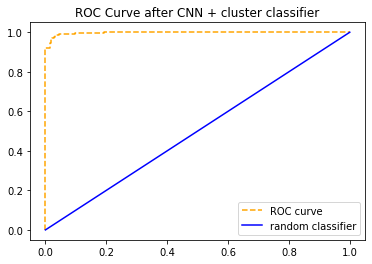

In [461]:
y_pred = best_model.predict(x_test_tf)
# get classification report and roc curve
y_test_int = y_test_one_hot[:,1].numpy()
y_pred_int = y_pred[:,1]


# plotting roc curve
fpr, tpr, thresholds = roc_curve(y_test_int, y_pred_int)
plt.title('ROC Curve after CNN + cluster classifier')
plt.plot(fpr, tpr, color='orange', linestyle='--', label='ROC curve');
plt.plot([0, 1], [0, 1], color='blue', label='random classifier');
plt.legend();

## Test on images from .dat files

### Recast images to tensors

In [417]:
len(x_test_pd.image.unique())

43

In [405]:
# load complete test tensors and image names
load_test_images = False
if load_test_images:
    test_image_names = utils.read_pickle('test_image_names.pkl')
    print('image names loaded')
    raman_specs = utils.read_pickle('test_images.pkl')
    print('full test images loaded')


In [462]:
# get a random image image and run through the pre-processing pipeline
image_ix = np.random.randint(0, high=len(raman_specs))
print(f'image {image_ix}: {raman_specs[image_ix][0]}')
image_vec = raman_specs[image_ix][1]

image_fp = pp.get_fingerprint_region(image_vec, start_ix=410)
print('finger-print region extracted')
image_or = pp.remove_sharp_peaks_2d_iter(image_fp, win_size=10, threshold=5)
print('sharp peaks removed')
image_fr = pp.remove_fluorescence(image_or, method='als')
print('fluorescence removed')
image_hz = image_fr - np.mean(image_fr, axis=1, keepdims=True)
print('horizontal mean subtracted')
image_ss = StandardScaler().fit_transform(image_hz)
print('cell complete')

image 1: D8.5_Pos1
finger-print region extracted
sharp peaks removed
fluorescence removed
horizontal mean subtracted
cell complete


In [463]:
n_samples, d = image_ss.shape

In [464]:
# sample an image, get tensors from it
k = 3
img = np.reshape(image_ss, (100,100,d))
# add 0 padding
# img_padded = np.pad(img, (2,2))[:,:,2:1342]
tensor_list = []
m,n, depth = img.shape
for r in range(m-(k-1)):
    for c in range(n-(k-1)):
        tensor_list.append(img[r:r+k, c:c+k, :])
tensor_np = np.array(tensor_list)

In [465]:
tensor_np.shape, img.shape, x_train_tf.shape

((9604, 3, 3, 930), (100, 100, 930), TensorShape([808, 5, 5, 930]))

In [466]:
def rotate_image_180(image):
    ''' rotate an image by 180 degrees '''
    return np.rot90(image,2,(0,1))

In [467]:
img_pred = best_model.predict(tensor_np)[:,1]
img_reshaped = np.reshape(img_pred, (m-2, n-2))
img_rot = rotate_image_180(img_reshaped)

ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 128 but received input with shape [None, 32]

In [ ]:
# get ground truth and nucleaize's best segmentation
nuclei_stain_image = plt.imread(f'./data/nuclei_stain/{raman_specs[image_ix][0]}.tif')
segmentation_image = plt.imread(f'./data/labelled/{raman_specs[image_ix][0]}.tiff')

# get window of interest from these images
temp_loc = (368,355)
temp_dims = 1312
nuclei_stain_image_cropped = nuclei_stain_image[temp_loc[0]:temp_loc[0]+temp_dims,temp_loc[1]:temp_loc[1]+temp_dims]
segmentation_image_cropped = segmentation_image[temp_loc[0]:temp_loc[0]+temp_dims,temp_loc[1]:temp_loc[1]+temp_dims]

# get title
image_name = raman_specs[image_ix][0]

In [ ]:
from matplotlib import colors as cm

In [ ]:
# plot image side by side with original image
norm = cm.Normalize(vmin=0, vmax=1)
fig, axs = plt.subplots(1, 3,figsize=(15,15))
im1 = axs[0].imshow(img_rot)
axs[0].set_title(f'Predicted image using Patch CNN\n{image_name}')
im2 = axs[1].imshow(nuclei_stain_image_cropped)
axs[1].set_title(f'Original image\n{image_name}')
im3 = axs[2].imshow(segmentation_image_cropped);
axs[2].set_title(f'State of the art Segmentation\n{image_name}')

# add colorbar
fig.colorbar(im1, ax=axs[0], shrink=.25)
fig.colorbar(im2, ax=axs[1], shrink=.25)
fig.colorbar(im3, ax=axs[2], shrink=.25);

# save figure
plt.savefig(f'results/patch_CNN_k=5/nn_image_{image_ix}');


In [364]:
'D9.5_Pos8' in x_test_pd.image.unique()

True

**Note** - decision made to not apply padding for the sake of time. Consider adding back in later

In [164]:
# UNFINISHED CODE (ADD LATER IF TIME PERMITS)
# for raman vectors, if 0 present (at a corner), fill in with means
def impute_small_tensor(tensor):
    # check if 0 in tensor
    if 0 not in tensor: return tensor
    pass

def impute_from_image_mean(tensor_np):
    pass

def get_test_image_tensors(raman_vec, k=3):
    ''' 
        Given an input vector, reshapes and finds all k x k
        clusters. Assumes tensors has already been pre-processed
    '''
    m, n_features = raman_vec.shape
    raman_tensor = np.reshape(raman_vec, (100,100, n_features))
    